# Error Characterization of HERMES
Understanding the sources of error of an integrator is essential for many reasons. It makes debugging much faster, adding new modules much easier, and operation more efficient.  

In [1]:
import rebound
import numpy as np
import time as timing

## Setup
First let's set up the problem consisting of a central star, massive planet and passive planetesimal. The planetesimal begins inside the $HSR$ boundary of the planet so that the simulation begins in pure IAS15 mode. We initialize the planetesimal such that the planet-planetesimal distance grows with time. Soon after, the planetesimal leaves the $HSR$ boundary and the simulation finishes in pure WHFAST mode. 

In Silburt et al. (2016) we calculate theoretical predictions for the error introduced, and we input these predictions so we can directly compare to our numerical tests.

In [2]:
def theory(params, x_array, choice, scale_factor):
    x0, x1, M, m, m_pl = params
    
    if choice == "dt":
        tau2 = x_array**2 / 12.
        a = x1
        rhHSR = x0*a*(m/(3*M))**(1./3.)
    elif choice == "HSR":
        tau2 = x0**2 / 12.
        a = x1
        rhHSR = x_array*a*(m/(3*M))**(1./3.)
    elif choice == "a":
        tau2 = x1**2 / 12.
        a = x_array
        rhHSR = x0*a*(m/(3*M))**(1./3.)
    M3 = M*m*m_pl
    term1 = M3/(a*rhHSR**3)
    term2 = m*m*m_pl/(rhHSR**4)
    term3 = -M3/(2*rhHSR*((a*a - rhHSR**2)**1.5))    #minor term, neg^x returns invalue value
    theoretical = (term1 + term2 + term3)*tau2*scale_factor
    axes[0].plot(x_array, theoretical, '+-',label='R3B theory')

In [14]:
def problem(HSR, dt, a_p, theta):
    #initialize the simulation
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hybarid"
    sim.ri_hybarid.switch_radius = HSR
    sim.ri_hybarid.CE_radius = 20.
    sim.dt = dt
    sim.testparticle_type = 1
    tmax = 7. * a_p**1.5
    sim.usleep = -1

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.collisions_track_dE = 1
    
    #massive bodies
    M = 1.
    m_p = 5e-5
    sim.add(m=M)
    sim.add(m=m_p,r=1.6e-4,a=a_p,e=0,inc=0.0001,f=0)
    sim.N_active = sim.N
    
    #planetesimal
    fac = 0.3
    if a_p < 1:
        fac = 0.7
    rr = 1e-3
    dr = rr*a_p*a_p*np.sin(theta - np.pi/2.)
    f = rr*np.sin(theta)
    vy = np.sin(theta)*(2*sim.G*m_p/rr)**0.5 / a_p**fac
    vx = 1.2*np.cos(theta)*(2*sim.G*m_p/rr)**0.5 / a_p
    #vy = 2*np.sin(theta)*(2*sim.G*m_p/rr)**0.5 
    #vx = 2*np.cos(theta)*(2*sim.G*m_p/rr)**0.5 
    m_pl = 1e-8
    sim.add(m=m_pl,r=4e-5,a=sim.particles[sim.N_active-1].x+dr,f=f)
    sim.particles[sim.N-1].vx -= vx
    sim.particles[sim.N-1].vy += vy
    
    #final physics initialization stuff
    sim.move_to_com()
    E0 = sim.calculate_energy()
    
    start_t = timing.time()
    sim.integrate(tmax)
    time = timing.time() - start_t
    E1 = sim.calculate_energy() - E0
    dE = np.fabs(E1/E0)
    
    #recall time is in units of yr/2pi
    return HSR, dt/(2*np.pi), a_p, dE, time, dE/np.fabs(E1), M, m_p, m_pl

### Choose Parameter Space
Now let's choose which variable we're investigating, either $dt$ or $HSR$, and set up the parameter space that we're going to search.

In [15]:
choice = "a"     #can be "HSR", "dt", or "a"
n_runs = 100       #number of searches in the parameter space

#set up parameter space
ones = np.ones(n_runs)
if choice == "HSR":
    dt = 1e-3*ones
    HSR = np.logspace(-2,1.7,n_runs)
    a = ones
elif choice == "dt":
    HSR = 6*ones
    dt = np.logspace(-5,0,n_runs)
    a = ones
elif choice == "a":
    HSR = 6*ones
    dt = 1e-3*ones
    a = np.logspace(-1,1,n_runs)
params = zip(HSR,dt,a,np.random.random(n_runs)*np.pi)

### Calculate
Calculate the results. This might take a minute or two.

In [16]:
import multiprocessing as mp
import pandas as pd

def execute(pars):
    return problem(pars[0],pars[1],pars[2],pars[3])

if __name__== '__main__':
    results = []
    pool = mp.Pool(processes=len(params))
    results.append(pool.map(execute, params))
    pool.close()
    pool.join()
    data = pd.DataFrame(results[0],columns=["HSR","dt","a","dE","time","scale_factor","M","m_p","m_pl"])

### Plot
Great, now let's plot the results, showing the energy error and elapsed time as a function of our chosen variable.

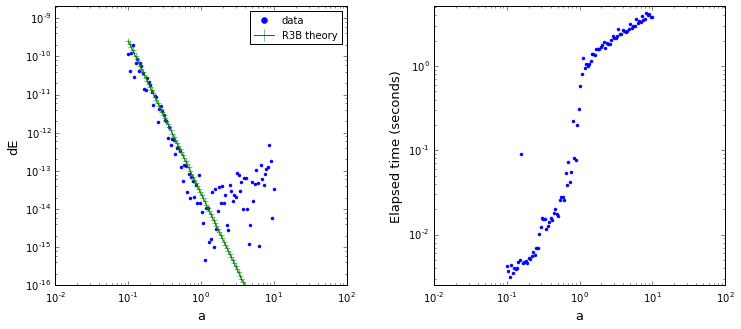

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

if choice == "HSR":
    x = data["HSR"]
    SS_params = data.loc[0,["dt","a","M","m_p","m_pl"]].values
elif choice == "dt":
    x = data["dt"]
    SS_params = data.loc[0,["HSR","a","M","m_p","m_pl"]].values
elif choice == "a":
    x = data["a"]
    SS_params = data.loc[0,["HSR","dt","M","m_p","m_pl"]].values
    
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,5))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(x,data["dE"],'.',label="data")
axes[0].set_ylim([1e-16,10*max(data["dE"])])
axes[0].set_xlim([min(x)/10., max(x)*10])
axes[0].set_xlabel(choice,fontsize=13)
axes[0].set_ylabel('dE',fontsize=13)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
theory(SS_params,x,choice,data["scale_factor"].mean())
axes[0].legend(loc='upper right',prop={'size':10}, numpoints=1, markerscale=2)
axes[1].plot(x,data["time"],'.')
axes[1].set_ylim([0.8*data["time"].min(),1.2*data["time"].max()])
axes[1].set_xlabel(choice,fontsize=13)
axes[1].set_ylabel('Elapsed time (seconds)',fontsize=13)
axes[1].set_yscale('log')